### Download the required packages

In [65]:
!pip install sktime --quiet
!pip install pyts --quiet
!pip install tsfresh --quiet
!pip install git+https://github.com/gon-uri/detach_rocket --quiet

### Download a dataset from the UCR archive

You can get a description of the datasets in the following webpage: https://www.timeseriesclassification.com/dataset.php

In [ ]:
from detach_rocket.utils_datasets import fetch_ucr_dataset
from pyts.datasets import ucr_dataset_list

# Download Dataset
selected_dataset = ['Computers']
print("Selected dataset:", selected_dataset)
current_dataset = fetch_ucr_dataset(selected_dataset[0])

print(" ")
# You can later try other UCR datasets (First use Computers dataset)
dataset_list = ucr_dataset_list()
print("All UCR Datasets:", dataset_list)

Selected dataset: ['Computers']
 
All UCR Datasets: ['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Car', 'Chinatown', 'ChlorineConcentration', 'CinCECGtorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes', 'ElectricDevices', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate'

### Create the corresponding Train and Test matrices

We unpack the dictionary downloaded form the UCR into the train and test matrices that we will use for training our models.

In [72]:
import numpy as np

# Create data matrices and remove possible rows with nans or infs

print(f"Dataset Matrix Shape: ( # of instances , time series length )")
print(f" ")

# Train Matrix
X_train = current_dataset['data_train']
print(f"Train Matrix Shape: {X_train.shape}")

# This part is to make shure there is no nans of inf in the data
non_nan_mask_train = ~np.isnan(X_train).any(axis=1)
non_inf_mask_train = ~np.isinf(X_train).any(axis=1)
mask_train = np.logical_and(non_nan_mask_train,non_inf_mask_train)
X_train = X_train[mask_train]

# We create the labels
y_train = current_dataset['target_train']
y_train = y_train[mask_train]

print(f" ")

# Test Matrix
X_test = current_dataset['data_test']
print(f"Test Matrix Shape: {X_test.shape}")

# This part is to make shure there is no nans of inf in the data
non_nan_mask_test = ~np.isnan(X_test).any(axis=1)
non_inf_mask_test = ~np.isinf(X_test).any(axis=1)
mask_test = np.logical_and(non_nan_mask_test,non_inf_mask_test)
X_test = X_test[mask_test]

y_test = current_dataset['target_test']
y_test = y_test[mask_test]

# Print the different unique classes
print(f" ")
print(f"Unique Classes: {np.unique(y_train)}")
number_of_classes = len(np.unique(y_train))

Dataset Matrix Shape: ( # of instances , time series length )
 
Train Matrix Shape: (250, 720)
 
Test Matrix Shape: (250, 720)
 
Unique Classes: [1 2]


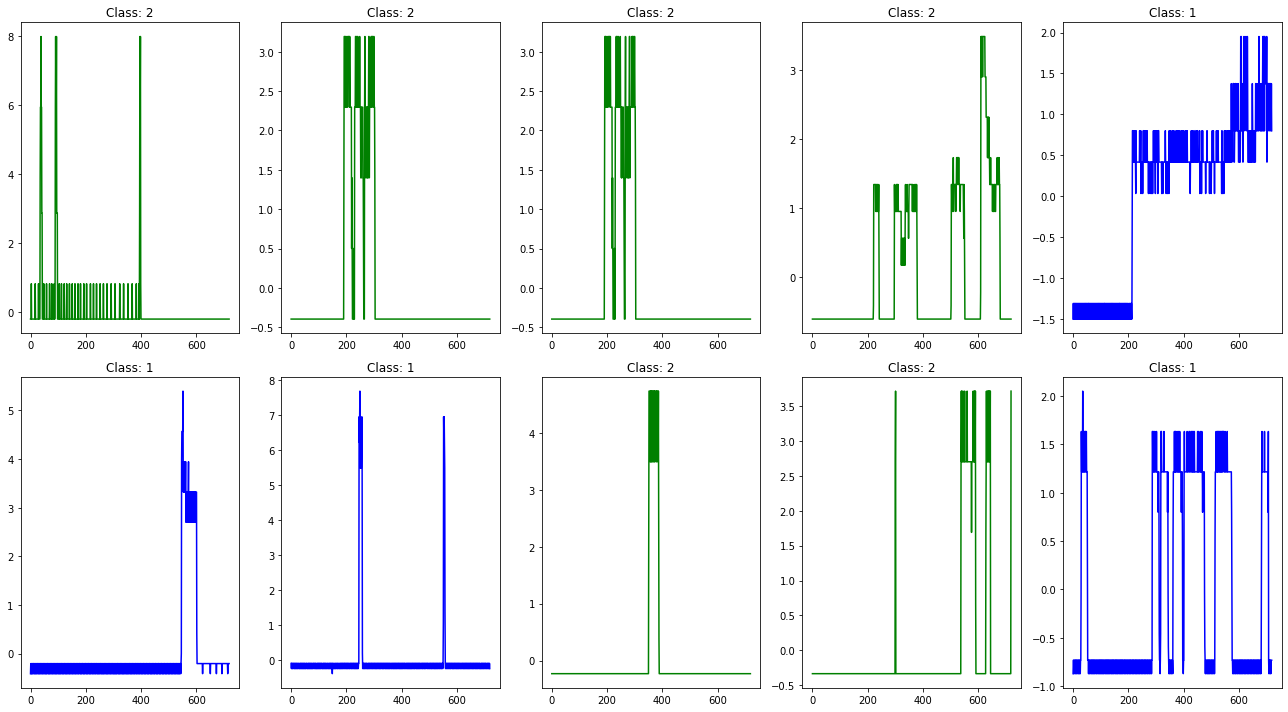

In [73]:
# Plot the 10 instances of each class in a subplot
import matplotlib.pyplot as plt

# Create a dictionary to map the class to a color
color_dict = {0:'red',1:'blue',2:'green',3:'yellow',4:'black',5:'orange',6:'purple',7:'pink',8:'brown',9:'cyan', -1:'cyan'}

# Plot the first 10 instances
plt.figure(figsize=(18,10))
for i in range(10):
    # pick random instance
    idx = np.random.randint(0,X_train.shape[0])
    plt.subplot(number_of_classes,5,i+1)
    plt.plot(X_train[idx],color=color_dict[y_train[idx]])
    plt.title(f"Class: {y_train[idx]}")
plt.tight_layout()
plt.show()


### Create a set of features from the time series

We will define a function to create features from the time series. The function takes as input a Matrix of size (num_instances, num_timesteps) and returns a matrix of size (num_instances, num_features) where num_features is the number of features extracted from the time series. We define what features we want to extract, for example mean, std, median, q25, q75, etc.

In [96]:
def extract_features(X):
    # Create a matrix to store the features
    num_instances = X.shape[0]
    features_names = ['mean','std','median','q25','q75','min','max','sum','var','abs_sum','squared_sum','cubed_sum']
    num_features = len(features_names)
    features = np.zeros((num_instances,num_features))
    
    # Extract the features
    features[:,0] = np.mean(X,axis=1)
    features[:,1] = np.std(X,axis=1)
    features[:,2] = np.median(X,axis=1)
    features[:,3] = np.percentile(X,25,axis=1)
    features[:,4] = np.percentile(X,75,axis=1)
    features[:,5] = np.min(X,axis=1)
    features[:,6] = np.max(X,axis=1)
    features[:,7] = np.sum(X,axis=1)
    features[:,8] = np.var(X,axis=1)
    features[:,9] = np.sum(np.abs(X),axis=1)
    features[:,10] = np.sum(X**2,axis=1)
    features[:,11] = np.sum(X**3,axis=1)
    
    return features, features_names

In [87]:
X_train_features, features_names = extract_features(X_train)
X_test_features, features_names = extract_features(X_test)

print(f"Train Features Shape: {X_train_features.shape}")
print(f"Test Features Shape: {X_test_features.shape}")

Train Features Shape: (250, 12)
Test Features Shape: (250, 12)


### Create a Function to train and evaluate a Logistic Regression Classifier

We will create a simple function to train and evaluate a logistic regression classifier using sci-kit learn.

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Define a function to train and evaluate a logistic regression classifier
def train_and_evaluate(X_train, y_train, X_test, y_test, verbose=True):
    # Create the classifier
    clf = LogisticRegression(max_iter=1000, penalty='l2')

    # Fit the classifier
    clf.fit(X_train,y_train)

    # Predict the train set
    y_pred_train = clf.predict(X_train)

    # Calculate the accuracy
    accuracy_train = accuracy_score(y_train,y_pred_train)

    # Predict the test set
    y_pred_test = clf.predict(X_test)

    # Calculate the accuracy
    accuracy_test = accuracy_score(y_test,y_pred_test)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred_test)

    if verbose:
        print(f"Train Accuracy: {accuracy_train}")
        print(f" ")
        print(f"Test Accuracy: {accuracy_test}")
        print(f" ")
        print(f"Confusion Matrix on Test Set: ")
        print(conf_matrix)

    return accuracy_train, accuracy_test, conf_matrix, clf

### Train and evaluate the models

We will now train and evaluate the classifier for both the raw data and the extracted features and compare the results.

In [92]:
# Train and evaluate the classifier for the raw data
print(f"Raw Data Results:")
print(f" ")
acc_train_raw, acc_test_raw, conf_matrix_raw, classifier_raw = train_and_evaluate(X_train, y_train, X_test, y_test)

Raw Data Results:
 
Train Accuracy: 1.0
 
Test Accuracy: 0.496
 
Confusion Matrix on Test Set: 
[[62 63]
 [63 62]]


In [94]:
# Train and evaluate the classifier for the extracted features
print(f"Extracted Features Results:")
print(f" ")
acc_train_features, acc_test_features, conf_matrix_features, classifier_features = train_and_evaluate(X_train_features, y_train, X_test_features, y_test)

Extracted Features Results:
 
Train Accuracy: 0.696
 
Test Accuracy: 0.692
 
Confusion Matrix on Test Set: 
[[74 51]
 [26 99]]


### Analize Feature Relevance

We can analyze the relevance of each extracted feature by looking at the coefficients of the logistic regression classifier. The higher the absolute value of the coefficient, the more relevant the feature is. We plot the name of the feature on the x-axis (present in features_names) and the coefficient relevance on the y-axis.

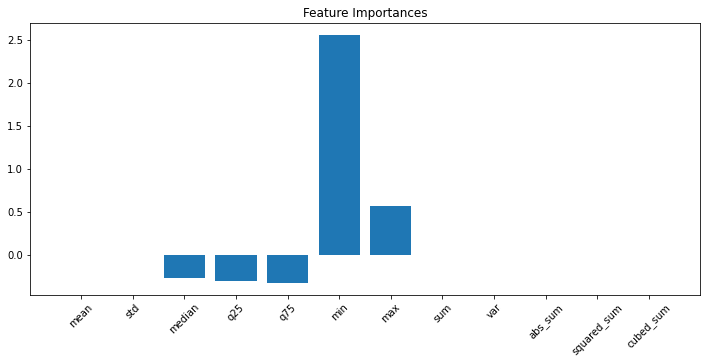

In [97]:
# Get the coefficients
coefficients = clf.coef_

# Plot the feature importances
plt.figure(figsize=(12,5))
plt.bar(features_names,coefficients[0])
plt.xticks(rotation=45)
plt.title('Feature Importances')
plt.show()

### Exercises

1) Compare both strategies (the one using the raw data and the one using the features), which strategy seems to work better?

2) Study the plotted instances and try to define features that are relevant to the classification task. Add these features to those created by the function and see if the classification accuracy increases.

3) Now try changing the classifier for non-linear one to improve the classification accuracy (you can try with a Random Forest).